## XG Boost Base

### Data Preparation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import sys

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer, KNNImputer
sys.path.insert(0, '../../src')

from utils import df_to_xarray,read_xarray

try:
    import xgboost
except ImportError as ex:
    print("Error: the xgboost library is not installed.")
    xgboost = None

/burg/glab/users/sk4973/venv2/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(
2022-12-24 19:11:35.343151: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/apps/slurm/current/lib64/slurm:/cm/shared/apps/slurm/current/lib64
2022-12-24 19:11:35.343194: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Reading Data
dir_name="../../data/member_001"

chl,mld,sss,sst,u10,xco2,icefrac,patm,pco2=read_xarray(dir_name)

mld=mld.isel(bnds=0)
sss=sss.isel(bnds=0)
sst=sst.isel(bnds=0)
xco2=xco2.isel(bnds=0)


mld['time'] =mld.time.indexes['time'].to_datetimeindex()
sss['time'] =sss.time.indexes['time'].to_datetimeindex()
sst['time'] =sst.time.indexes['time'].to_datetimeindex()
xco2['time'] =xco2.time.indexes['time'].to_datetimeindex()

/burg/glab/users/sk4973/venv2/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'cfgrib' loading failed:
ecCodes library not found using ['eccodes', 'libeccodes.so', 'libeccodes']
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/tmp/ipykernel_403712/3409989473.py:12: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  mld['time'] =mld.time.indexes['time'].to_datetimeindex()
/tmp/ipykernel_403712/3409989473.py:13: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  sss['time'] =sss.time.indexes['time'].to_datetimeindex(

In [3]:

pco2['time'] = pco2.time.dt.strftime("%Y-%m")
chl['time'] = chl.time.dt.strftime("%Y-%m")
mld['time'] =mld.time.dt.strftime("%Y-%m")
sss['time'] =sss.time.dt.strftime("%Y-%m")
sst['time'] =sst.time.dt.strftime("%Y-%m")
xco2['time'] =xco2.time.dt.strftime("%Y-%m")


data_read=xr.merge([chl.Chl,chl.Chl_socat,mld.MLD,mld.MLD_socat,sst.SST,sst.SST_socat,sss.SSS,sss.SSS_socat,xco2,pco2.pCO2,pco2.pCO2_socat])

tmp_data=data_read.to_dataframe().reset_index()
tmp_data=tmp_data.drop(columns=['TLONG', 'TLAT', 'time_bnds'])

check=tmp_data.set_index(["time","ylat","xlon"]).to_xarray()

tmp_data_final=tmp_data[tmp_data.time != "1982-01"]
tmp_data_final=tmp_data_final[tmp_data_final.time != "2017-02"]

features_socat = ['time','xlon', 'ylat','MLD_socat', 'SST_socat', 'SSS_socat','Chl_socat', 'XCO2','pCO2_socat']
features = ['time','xlon', 'ylat','MLD','SST','SSS','Chl','XCO2','pCO2']

# create separate dataframe for socat
combined_socat=tmp_data_final[features_socat]
combined=tmp_data_final[features]

combined_socat.dropna(subset = ["pCO2_socat"],inplace=True)
combined_socat= combined_socat[combined_socat['pCO2_socat']!=0]

combined.dropna(subset = ["pCO2"],inplace=True)
combined= combined[combined['pCO2']!=0]

/burg/glab/users/sk4973/venv2/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


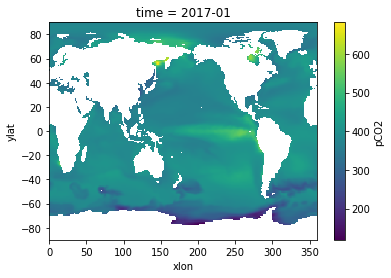

In [10]:
check.pCO2[420].plot()

In [4]:
X_socat=combined_socat.iloc[:,3:-1]
X=combined.iloc[:,3:-1]
y=combined.loc[:,'pCO2']
y_socat=combined_socat.loc[:,'pCO2_socat']

### Imputation

In [5]:
# Two Different Imputation Methods
# KNNImputer
# imp = KNNImputer(n_neighbors=2)
# X=imp.fit_transform(X)
# X_socat=imp.fit_transform(X_socat)

# SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X=imp.fit_transform(X)
X_socat=imp.fit_transform(X_socat)

In [6]:
X_socat_train, X_socat_test, y_socat_train, y_socat_test = train_test_split(
    X_socat, y_socat, test_size=0.3, random_state= 73)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state= 73)

### XG Boost Modeling

In [7]:
from sklearn.model_selection import GridSearchCV

parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'learning_rate': [0.01, 0.05, .07], #so called `eta` value
              'n_estimators': [30,50]}


if xgboost is not None: 
    xgb_reg = xgboost.XGBRegressor(random_state=42)
    xgb_grid = GridSearchCV(xgb_reg,
                        parameters,
                        cv = 3,
                        n_jobs = 5,
                        verbose=True)
    xgb_grid.fit(X_socat_train, y_socat_train)
    

Fitting 3 folds for each of 6 candidates, totalling 18 fits


### Final Result

Test Set RMSE:28.43698261274142

Whole Grid Rmse:37.709863752151215

In [8]:
final_model =xgb_grid.best_estimator_
y_pred = final_model.predict(X_test)
val_error = np.sqrt(mean_squared_error(y_test, y_pred,squared=True)) # Not shown
print("Best Test RMSE:", val_error)    

Best Test RMSE: 35.22571395795329


In [9]:
## Whole Grid
y_pred=final_model.predict(X)
final_rmse=np.sqrt(mean_squared_error(y, y_pred,squared=True))
error=y-y_pred
final_rmse

35.253211044321155

### Visualization of the Residual

In [10]:
combined["residual"] = error
combined["pred"] = y_pred

combined_tmp=combined.set_index(["time","ylat","xlon"])
result_data=combined_tmp[["residual"]]
result_data = result_data.sort_index()

In [11]:
combined_tmp=combined.set_index(["time","ylat","xlon"])
pred_data=combined_tmp[["pred","pCO2"]]
pred_data = pred_data.sort_index()


In [12]:
ds = result_data.to_xarray()
ds_pred = pred_data.to_xarray()

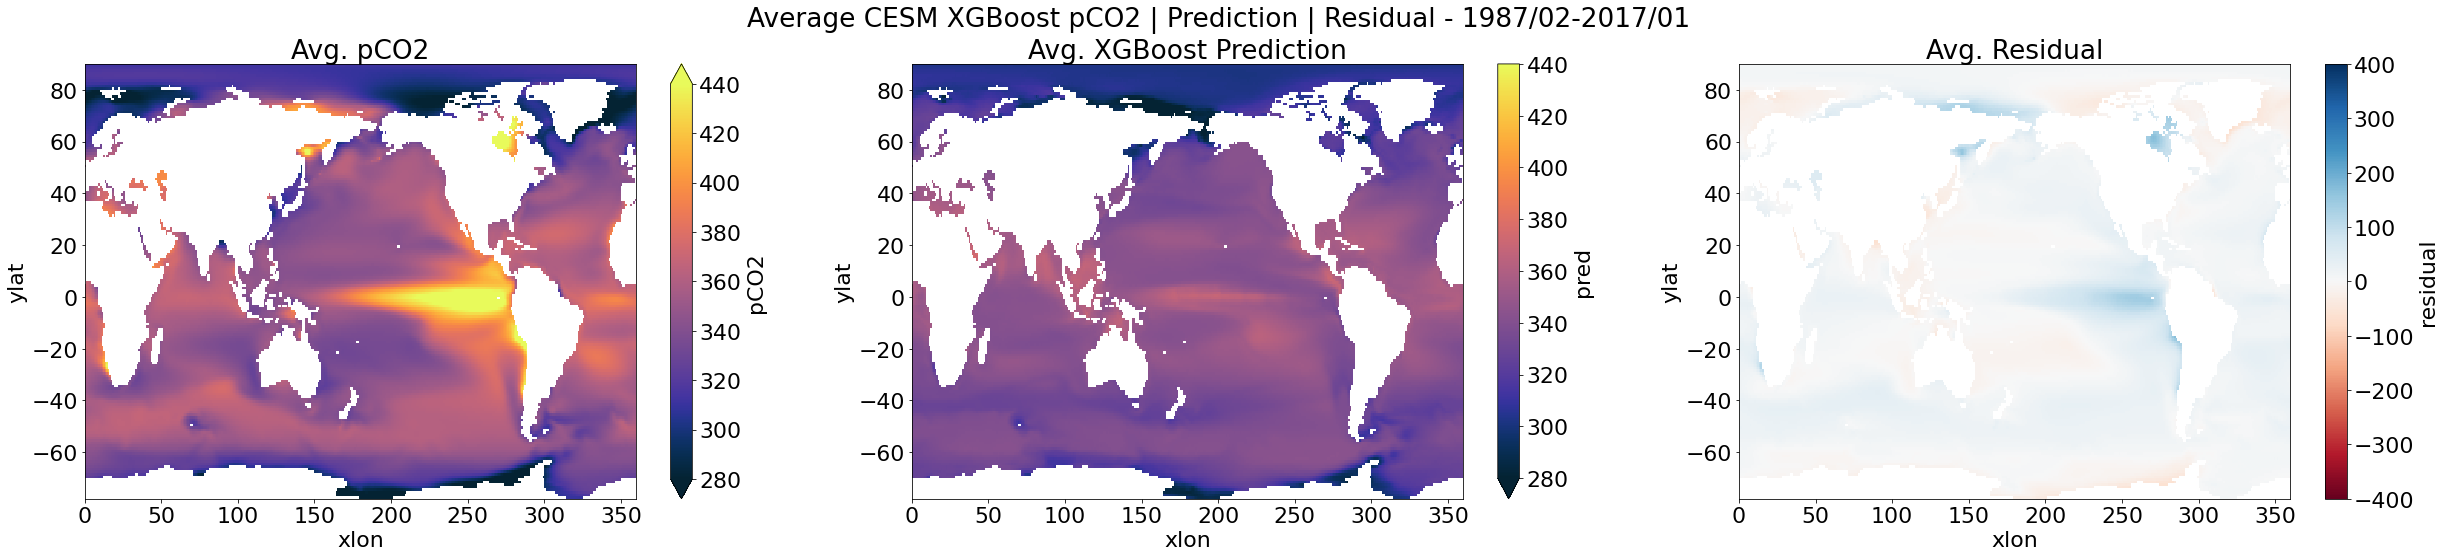

In [14]:
import matplotlib.colors as mcolors
import cmocean as cm

plt.rcParams.update({'font.size': 22})
norm = mcolors.Normalize(vmin=280, vmax = 440)
figure, axis = plt.subplots(1, 3,figsize=(42, 8))

ds_pred.pCO2.mean('time').plot(ax = axis[0],cmap = cm.cm.thermal,norm=norm)
axis[0].set_title("Avg. pCO2")

ds_pred.pred.mean('time').plot(ax = axis[1],cmap = cm.cm.thermal,norm=norm)
axis[1].set_title("Avg. XGBoost Prediction")


norm2 = mcolors.TwoSlopeNorm(vmin=-400, vmax = 400, vcenter=0)

ds.residual.mean('time').plot(ax = axis[2],cmap = "RdBu",norm=norm2)
axis[2].set_title("Avg. Residual")

figure.suptitle("Average CESM XGBoost pCO2 | Prediction | Residual - 1987/02-2017/01")

plt.savefig("../../assets/figure2.2_xgboost_socat.jpg")